This workbook is created based on the presentation at the Data Incubator [here](https://github.com/thedataincubator/DS30_4/blob/master/RLtalk.ipynb). I modify the workbook to:
- Incorporate a more object-oriented approach
- Draw more similarity between Multi Armed Bandits and A/B test by simulating the reward based a binomial distribution (instead of normal)

In [20]:
## Source 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from abc import ABC, abstractmethod
import seaborn as sns

Let's create a base class for our Multi-armed bandit.

In [21]:
class Bandit(ABC):
    def __init__(self, arm_values, reward_function):
        self.arm_values = arm_values
        self.est_values = np.zeros(len(arm_values))
        self.K = np.zeros(len(arm_values))
        self.numArms = len(arm_values)
        self.reward = reward_function
        
    def get_reward(self, action):
        return self.reward(self.arm_values[action])

    @abstractmethod
    def choose_strategy(self):
        pass
    
    @abstractmethod
    def update(self, action, reward):
        pass
    
    def reset(self, arm_values):
        self.est_values = np.zeros(len(arm_values))
        self.K = np.zeros(len(arm_values))
        self.arm_values = arm_values

For this approach, we maintain an estimation of reward for each arm. We are inclined to choose the arm with the highest estimated reward, but with probability $\epsilon$, we pick an arm randomly.

In [22]:
# Bandit using Greedy Epsilon approach
class Bandit_Epsilon(Bandit):
    def __init__(self, arm_values, reward_function, epsilon):
        super(Bandit_Epsilon, self).__init__(arm_values, reward_function)
        self.epsilon = epsilon 
    
    def choose_strategy(self):
        rand_num = np.random.random()
        if self.epsilon > rand_num:
            return np.random.randint(10)
        else:
            # with probability of epsilon we pick the estimated max
            return np.argmax(self.est_values)
    
    def update(self, action, reward):
        self.K[action]+= 1
        alpha = 1./ self.K[action]
        
        # running average of reward
        self.est_values[action] += alpha * (reward - self.est_values[action])

In [27]:
# Bandit using Randomized Probability matching
class Bandit_RPM(Bandit):
    def __init__(self, arm_values, reward_function):
        super(Bandit_RPM, self).__init__(arm_values, reward_function)
        self.parms = [[1., 1.] for i in arm_values]
        
    def choose_strategy(self):
        # Thompson sampling to choose action
        # Not choosing the max posterior BUT
        # Sample from each posterior and choose the max of the sample
        # see more at: https://agrawal.wikischolars.columbia.edu/file/view/Lecture+4.pdf
        samples = np.zeros(self.numArms)
        for key in range(self.numArms):
            samples[key] = np.random.beta(self.parms[key][0], self.parms[key][1])
        
        return np.argmax(samples)

    def update(self, action, reward):
        a, b = self.parms[action]
        # Posterior update of beta
        self.parms[action] = (a + reward, b + 100 - reward)      
        
    def reset(self, arm_values):
        self.est_values = np.zeros(len(arm_values))
        self.K = np.zeros(len(arm_values))
        self.parms = [[1., 1.] for i in arm_values]
        self.arm_values = arm_values

Let's start with our simulation. The arm_values are uniform random.

In [82]:
def experiment(bandit, Npulls):
    history = []
    for i in range(Npulls):
        action = bandit.choose_strategy()
        R = bandit.get_reward(action)
        bandit.update(action, R)
        history.append(R)
    return np.array(history)

In [125]:
np.random.seed(42)
Nexp = 300
Npulls = 3000

tmpVal = [0.0] * 10

def binom_reward(param):
    return np.random.binomial(100, param)

bandits = [Bandit_Epsilon(tmpVal, binom_reward, 0.0)
           ,Bandit_Epsilon(tmpVal, binom_reward, 0.01)
           ,Bandit_Epsilon(tmpVal, binom_reward, 0.1)
           ,Bandit_Epsilon(tmpVal, binom_reward, 0.3)
           ,Bandit_RPM(tmpVal, binom_reward)]

labels = ['p=0.0'
         ,'p=0.01'
         ,'p=0.1'
         ,'p=0.3'
         ,'rpm']

res = [np.zeros(Npulls)] * len(bandits)

for i in range(Nexp):
    arm_values = np.random.uniform(0.01, 0.1, 10)
    for model in range(len(bandits)):
        bandits[model].reset(arm_values)
        res[model] = res[model] + experiment(bandits[model], Npulls)
        
        # Note:
        # cannot use res[model] += res[model]

for model in range(len(bandits)):
    res[model] /= np.float(Nexp)
    

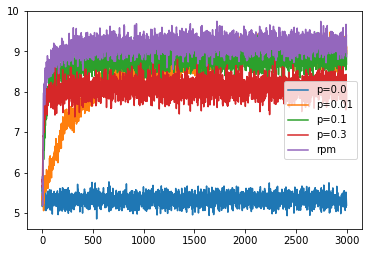

In [132]:
for i in range(len(bandits)):
    plt.plot(res[i], label = labels[i])
plt.legend()

The plot above shows that, except for the greedy approach with p = 0.0, after around 200 pulls, we are able to reach a stable level of reward. We can view the histogram as follows:

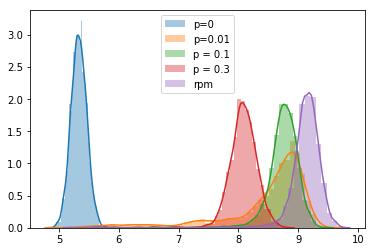

In [126]:
for i in range(len(bandits)):
    sns.displot(res[i], label = labels[i])
plt.legend()

In [129]:
for i in range(len(bandits)):
    print(np.percentile(res[i], 0.01))

4.88065866667
5.10398533333
5.56099633333
5.65233033333
5.27363766667


There appears to be no monotonic relationship between $\epsilon$ and the performance of the algorithm: when p = 0.3, the performance is not better than when p = 0.1 or p = 0.01. Overall, the Thompson sampling method has the best performance.

# A different reward
In the example above, I consider the reward as a Binomial random variable. I would like to see what happen if we use a different reward, hence a different update.

In [ ]:
class Bandit_RPM_Normal:
    def __init__(self, arm_values):
        self.parms = arm_values
        self.numArms = len(arm_values)
        self.K = np.zeros(self.numArms)
        self.K[action]+= 1
        alpha = 1./ self.K[action]
        
        # running average of reward
        self.est_values[action] += alpha * (reward - self.est_values[action])
        
    def choose_strategy(self):
        samples = np.zeros(self.numArms)
        for key in range(self.numArms):
            samples[key] = np.random.normal(self.parms[key][0], self.parms[key][1])
        
        return np.argmax(samples)
    
    def get_reward(self, action)
        sigma_2 = invgamma.rvs(a=3, scale =1, size = n)
        sigma = np.sqrt(sigma_2)
        z_i = np.random.normal(loc=0.2, scale=0.7, size = n)
        reward = np.random.normal(z_i, sigma)
        return reward

    def update(self, action, reward):
        a, b = self.parms[action]
        # Posterior update of beta
        self.parms[action] = (a + reward, b + 100 - reward)      

parms = []
real_arms = []
for i in range(10):
    # Posteior for real value
    # sigma_2 = invgamma.rvs(a=3, scale =1, size = n)
    # sigma = np.sqrt(sigma_2)
    sigma = 0.3
    z_i = np.random.normal(loc=0.2, scale=0.7, size = n)
    
    parms.append((z_i, sigma))

bandits = Bandit_RPM_Normal(parms)

numPulls = 3000
for i in range(numPulls):
    